# Project setup

Resources:
* https://www.youtube.com/watch?v=K0lWSB2QoIQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=15

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# define mean and std
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [ ]:
# download dataset
!wget https://github.com/callezenwaka/facebook-pytorch/blob/main/capstone-project-1/data.zip?raw=true && unzip -qq data.zip?raw=true
!rm -rf data.zip?raw=true

--2021-10-21 04:34:33--  https://github.com/callezenwaka/facebook-pytorch/blob/main/capstone-project-1/data.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/callezenwaka/facebook-pytorch/raw/main/capstone-project-1/data.zip [following]
--2021-10-21 04:34:34--  https://github.com/callezenwaka/facebook-pytorch/raw/main/capstone-project-1/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/callezenwaka/facebook-pytorch/main/capstone-project-1/data.zip [following]
--2021-10-21 04:34:34--  https://raw.githubusercontent.com/callezenwaka/facebook-pytorch/main/capstone-project-1/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserco

# Data Transformations

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# DataLoaders and Data Visualization

In [ ]:
data_dir = 'data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

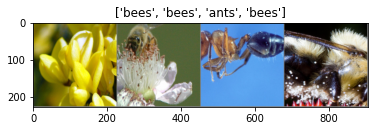

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
output = torchvision.utils.make_grid(inputs)
# preview image samples
imshow(output, title=[class_names[x] for x in classes])

# Trainng Model

In [ ]:
# train model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Load Pretrained Model

In [ ]:
##################### version one ############################
# uncomment to run
# Load a pretrained model and reset final fully connected layer.

# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model.fc = nn.Linear(num_ftrs, 2)

# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# # Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001)
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

In [ ]:
##################### version two ############################
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
# save trained model
torch.save(model.state_dict(), 'bees_and_ants.pt')

# Make Prediction

In [ ]:
import numpy as np
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

In [ ]:
img_file_path = 'ant.jpg'
labels = ['ants', 'bees']
model_path = 'bees_and_ants.pt'

In [ ]:
transform = transforms.Compose([transforms.CenterCrop(360), 
                               transforms.ToTensor()
                               ])
model = models.resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=len(labels), bias=True) # change last fc layer of resnet
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda'))) # load pretrained model
model.eval() # set to evaluation mode

In [ ]:
img = Image.open(img_file_path) # take an image file
img = transform(img) # tranform the image file into tensor

In [ ]:
prediction = model(img.unsqueeze(0)) # pass image file into model and get prediction
result = torch.argmax(prediction) # get result index

In [ ]:
print(f"This is a {labels[result]}")

This is a ants
